# Случайный лес (Random Forest)

В программе:
* обучение леса и сравнение с деревом
* подбор гиперпараметров леса
* зависимость качества от числа деревьев

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.datasets import fetch_california_housing

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

In [ ]:
RANDOM_STATE = 42

In [ ]:
data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

## 1. Сравнение дерева и леса

In [ ]:
dt = DecisionTreeRegressor()

cross_val_score(dt, X, y, cv=3, scoring='r2').mean()

0.32344822677735985

In [ ]:
rf = RandomForestRegressor()

cross_val_score(rf, X, y, cv=3, scoring='r2').mean()

0.6527700825220905

## 2. Подбор гиперпараметров леса

Для подбора гиперпараметров модели лучше всего действовать так:
* разбиваем данные на *train* и *test*
* на *train* по кросс-валидации при помощи `GridSearchCV` ищем наилучшие гиперпараметры модели
* оцениваем качество модели с наилучшими гиперпараметрами на *test*

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

### Гиперпараметры леса (random forest)

* `n_estimators=100` - число деревьев в лесе 
* `oob_score=False` - вычисляем ли out-of-bag ошибку
* `n_jobs=None` - на сколько процессов распараллеливаем вычисления
* гиперпараметры деревьев (обсуждали раньше):
  + `criterion='squared_error'`
  + `max_depth=None`
  + `min_samples_split=2`
  + ...
  + `random_state=None`


In [ ]:
params = {'n_estimators': np.arange(10, 200, 20),
          'max_depth': np.arange(2, 20, 3)}

gs = GridSearchCV(RandomForestRegressor(), params, cv=3, scoring='r2', verbose=2)

gs.fit(Xtrain, ytrain)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.3s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.4s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.3s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.6s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.6s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.6s
[CV] END .......................max_depth=2, n_estimators=70; total time=   0.8s
[CV] END .......................max_depth=2, n_estimators=70; total time=   1.0s
[CV] END .......................max_depth=2, n_

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([ 2,  5,  8, 11, 14, 17]),
                         'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190])},
             scoring='r2', verbose=2)

In [ ]:
gs.best_score_, gs.best_estimator_

(0.7931685623299155, RandomForestRegressor(max_depth=17, n_estimators=190))

In [ ]:
params = {'max_features': [None, 'sqrt', 'log2']}

gs = GridSearchCV(RandomForestRegressor(n_estimators = 190, max_depth = 17), params, cv=3, scoring='r2', verbose=2)

gs.fit(Xtrain, ytrain)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..................................max_features=None; total time=  12.4s
[CV] END ..................................max_features=None; total time=  13.2s
[CV] END ..................................max_features=None; total time=  12.2s
[CV] END ..................................max_features=sqrt; total time=   3.7s
[CV] END ..................................max_features=sqrt; total time=   4.7s
[CV] END ..................................max_features=sqrt; total time=   3.8s
[CV] END ..................................max_features=log2; total time=   5.0s
[CV] END ..................................max_features=log2; total time=   5.9s
[CV] END ..................................max_features=log2; total time=   5.6s


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_depth=17, n_estimators=190),
             param_grid={'max_features': [None, 'sqrt', 'log2']}, scoring='r2',
             verbose=2)

In [ ]:
gs.best_score_, gs.best_estimator_

(0.8062933573574306,
 RandomForestRegressor(max_depth=17, max_features='log2', n_estimators=190))

Теперь проверим полученную модель на тестовых данных

In [ ]:
model = RandomForestRegressor(n_estimators = 190, max_depth = 17, max_features='log2')

model.fit(Xtrain, ytrain)

pred = model.predict(Xtest) 

r2_score(ytest, pred)

0.8140511795198865

## 3. Поведение модели при увеличении числа деревьев

Text(0, 0.5, 'r2')

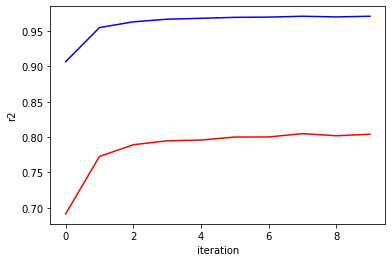

In [ ]:
r2_train = []
r2_test = []

for n in range(2, 50, 5):
    model = RandomForestRegressor(n_estimators = n, n_jobs=-1)
    model.fit(Xtrain, ytrain)

    pred_train = model.predict(Xtrain)
    pred_test = model.predict(Xtest)

    r2_train.append(r2_score(ytrain, pred_train))
    r2_test.append(r2_score(ytest, pred_test))

plt.plot(r2_train, color='blue')
plt.plot(r2_test, color='red')
plt.xlabel('iteration')
plt.ylabel('r2')

Эти графики подтверждают теорию: при увеличении числа деревьев в лесе качество тоже только увеличивается.

На практике качество в какой-то момент выходит на асимптоту и начинает увеличиваться совсем незначительно. Поэтому обычно выбирают минимальное число деревьев в лесе, при котором качество уже почти не растет - ведь лес с большим числом деревьев обучается очень долго.